# Lab 2 Processing High Temporal Resolution TRMM Data
**NIkos Kordalis**

**On Moodle we have provided data for each of the months of the year 2000. Choose a geographic region (at least 100x100 pixels, so you can see something), preferably with significant rainfall events (e.g., don’t choose the Sahara Desert as you won’t see anything from TRMM). The Indian Monsoon region, the central Congo, the South American Monsoon region, the Pacific Ocean, and the Atlantic Ocean are all good options, but feel free to choose somewhere that interests you.**

**Question 1: Using the 12 zip files, process one large HDF file for your region. This should have three datasets: (1) geotransform, (2) timestamps, and (3) precipitation. Precipitation should be as one large matrix (e.g., size of (x, y, time)). Please provide the code that you used to generate this dataset, and a screenshot showing the final dataset size. HINT: You can also unzip the files using python. You can also delete the raw files as you go to save disk space while you create your matrix. (30 points)**

In [1]:
import os 
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
from pyhdf.SD import SD, SDC
import datetime
import tables
import numpy as np
import matplotlib.pyplot as plt
import h5py
import dask.array as da
from matplotlib.colors import LogNorm

In [ ]:
base_dir = 'Year_2000/'
os.listdir(base_dir)

In [3]:
def read_trmm_HDF(fid):
    base_file = SD(fid, SDC.READ)
    data = base_file.select('precipitation').get().astype(float)
    data[data < 0.01] = np.nan
    return data.T

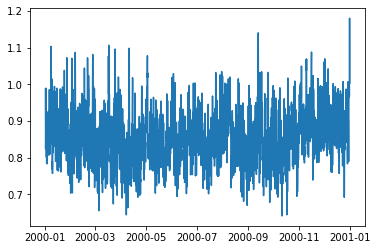

In [4]:
mn, times = [], []

sorted_list = os.listdir(base_dir) # sort it
sorted_list.sort()

for f in sorted_list:
    fid = os.path.join(base_dir, f)
    data = read_trmm_HDF(fid)
    mn.append(np.nanmean(data))
    date, hr = f.split('.')[1:3]
    time = datetime.datetime(int(date[:4]), int(date[4:6]), int(date[6:]), int(hr))
    times.append(time)
    #print(f, time.isoformat(),np.nanmean(data))

plt.close('all')
plt.plot(times, mn)

In [5]:
FILTERS = tables.Filters(complib='zlib', complevel=5)

In [6]:
if not os.path.exists('Year_2000.Stacked.hdf'): # if we dont already have a file called 2000.12.. make a new one
    h5file = tables.open_file('Year_2000.Stacked.hdf', mode='w', title='precipitation', filters=FILTERS)

In [7]:
ul_x = -180 
ul_y = 90 
res = 0.25 
gt = np.array([ul_x, res, 0, ul_y, 0, res*-1])
print(gt)

[-180.      0.25    0.     90.      0.     -0.25]


(1200, 160)
(1300, 60)


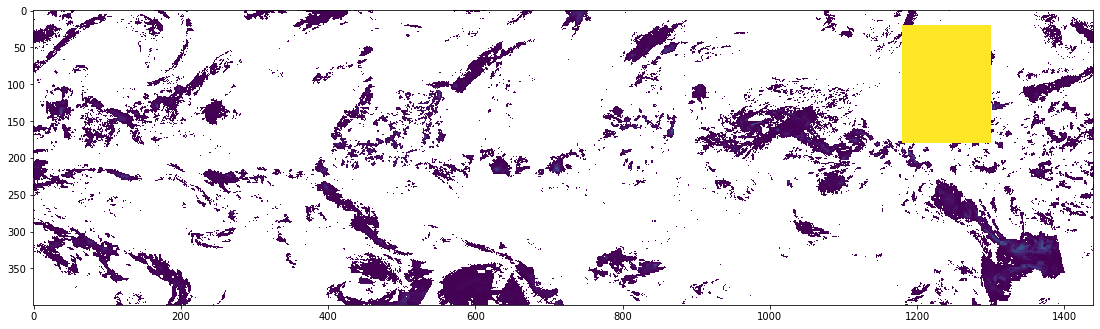

In [13]:
def lat_to_matrix(x, y):
    X = int(round((x - gt[0])/gt[1])) 
    Y = int(round((y - gt[3])/gt[5])) 
    return X, Y

xmin, xmax = 120, 145   #Delta of Lena river
ymin, ymax = 50, 75

xmin_ymin_matrix = lat_to_matrix(xmin, ymin)
xmax_ymax_matrix = lat_to_matrix(xmax, ymax)

print(xmin_ymin_matrix)
print(xmax_ymax_matrix)


xrange = [xmin_ymin_matrix[0], xmax_ymax_matrix[0]]
yrange = [xmin_ymin_matrix[1], xmax_ymax_matrix[1]]


data[yrange[1]:yrange[0],xrange[0]:xrange[1]]=80

plt.close('all')
fig = plt.figure(figsize=(19,20))

plt.imshow(data)


In [14]:
#plt.colorbar()
#subset2 = data[yrange[1]:yrange[0], xrange[0]:xrange[1]]
#print(subset2.shape)
#f, ax = plt.subplots(1,figsize=(15,10))
#plt.imshow(data) 

In [15]:
ds=data[yrange[1]:yrange[0],xrange[0]:xrange[1]].shape

In [16]:
SIZE = (ds[0], ds[1],len(mn))

In [17]:
ds = h5file.create_carray(h5file.root, 'precip', tables.Float32Atom(), (SIZE))
# h5file.root means we are putting the data on the
# top level and not in a sub group, tables.Float32Atom() is the type of the data
time = h5file.create_carray(h5file.root, 'time', tables.StringAtom(19), (len(mn),))# 19 character string (i. e. 2000-12-01 00:00:00)

In [18]:
# create array for whole gt
ds_geo = h5file.create_carray(h5file.root, 'gt', tables.Float32Atom(), (6,)) # gt is 6 long
ds_geo[:] = gt

In [19]:
# create array for sliced gt
ds_slice = h5file.create_carray(h5file.root, 'gt_slice', tables.Float32Atom(), (4,)) # xrange and yrange is 4 long
ds_slice[:] = xrange+yrange

In [ ]:
for i, t in enumerate(times): 
    print(i,t)
    time[i-1] = [t.isoformat()] 
    
for i, f in enumerate(os.listdir(base_dir)):
    if f.startswith('3B42'):
        print(i, f)
        data = read_trmm_HDF(os.path.join(base_dir, f))
        ds[:,:,i-1] = data[yrange[1]:yrange[0], xrange[0]:xrange[1]]
           
h5file.close()

In [21]:
x = h5py.File('Year_2000.Stacked.hdf', 'r')
print(x)
print(x.keys())
print(x['precip'].shape)

<HDF5 file "Year_2000.Stacked.hdf" (mode r)>
<KeysViewHDF5 ['gt', 'gt_slice', 'precip', 'time']>
(100, 100, 2928)


In [ ]:
import pylab as plt
data = da.from_array(x['precip'], chunks = (100, 100,1))
data[data < 0.1] = np.nan
mn = da.nanmean(data, 2)
mn = mn.compute()

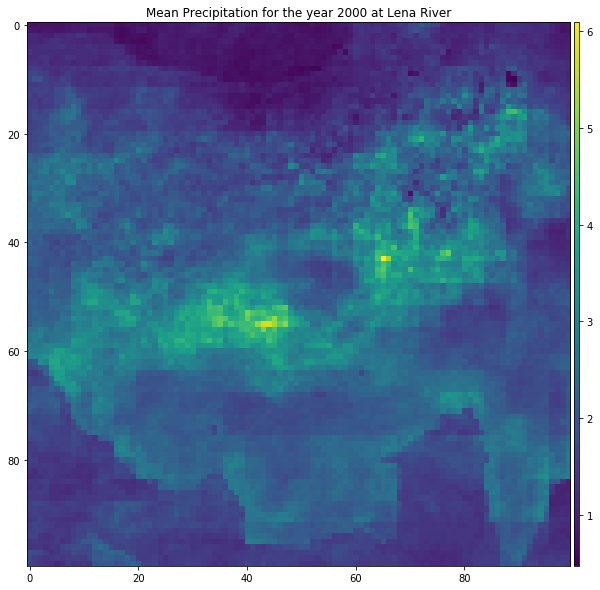

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
f, ax = plt.subplots(1,figsize=(15,10))
#plt.imshow(mn)
#plt.colorbar()

imy=plt.imshow((mn))
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.05)
plt.colorbar(imy, cax=cax)
ax.title.set_text('Mean Precipitation for the year 2000 at Lena River')

**Question 2: Create four maps showing seasonal (e.g, December-January-February, March-April-May, June-July-August, September-October-November) precipitation means over the same region you created your TRMM grid for. Your maps should have colorbars and scales. (20 points)**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal, gdalnumeric
import pandas as pd
import os, datetime
import h5py
import statsmodels.api as sm
import itertools

fid ='Year_2000.Stacked.hdf'
data = h5py.File(fid,'r')

In [2]:
print(data.keys())
print(data['precip'].shape)

<KeysViewHDF5 ['gt', 'gt_slice', 'precip', 'time']>
(100, 100, 2928)


In [3]:
PREC = np.array(data['precip'])
PREC[PREC < 0.1] = np.nan
#DATES=np.array(data['time'])

/Users/nikos/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [4]:
def conv_date(l):
    return datetime.datetime.strptime(l, '%Y-%m-%dT%H:%M:%S')


In [5]:
datestrings = np.array(data['time']).astype(str)
dates = list(map(lambda l: conv_date(l), datestrings))

In [11]:
seriesG = pd.Series( PREC[99, 99, :], index=dates)

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [13]:
def plot(data, series, season):
    plt.figure(figsize=(12,6))
    imc=plt.imshow(np.nanmean(data,axis=2))
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0.05)
    plt.colorbar(imc, cax=cax)
    ax.title.set_text('Mean Precipitation at Lena river for 2000 '+season)
    plt.show()

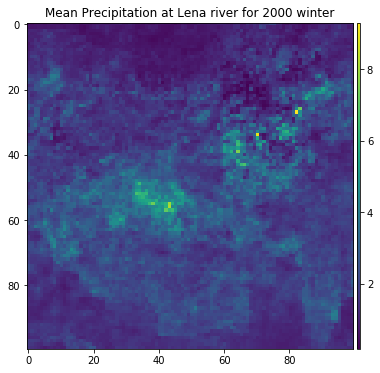

/Users/nikos/anaconda3/envs/BigData/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


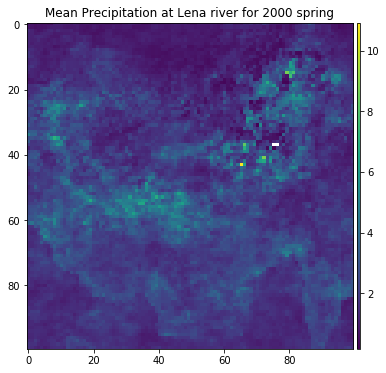

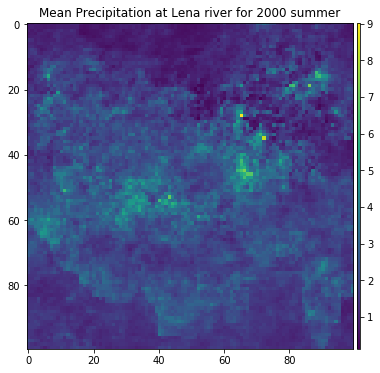

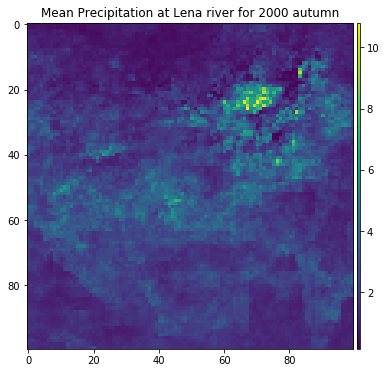

In [14]:
idx1 = np.logical_or(seriesG.index.month == 12, np.logical_or(seriesG.index.month == 1, seriesG.index.month == 2))
Winter_data = PREC[:, :, idx1]


idx2 = np.logical_or(seriesG.index.month == 3, np.logical_or(seriesG.index.month == 4, seriesG.index.month == 5))
Spring_data = PREC[:, :, idx2]

idx3 = np.logical_or(seriesG.index.month == 6, np.logical_or(seriesG.index.month == 7, seriesG.index.month == 8))
Summer_data = PREC[:, :, idx3]

idx4 = np.logical_or(seriesG.index.month == 9, np.logical_or(seriesG.index.month == 10, seriesG.index.month == 12))
Autumn_data = PREC[:, :, idx4]


plot(Winter_data, seriesG, 'winter')
plot(Spring_data, seriesG, 'spring')
plot(Summer_data, seriesG, 'summer')
plot(Autumn_data, seriesG, 'autumn')